In [ ]:
import os

import numpy as np
# import glob
import torch
# import scipy.io as sio
import matplotlib.pyplot as plt
# import cv2
import torch.fft as fft
# from tqdm import tqdm, trangel
import torch.nn.functional as F
import math
# import imageio
import torchvision.utils as vutils
# import re
# from torch.utils.tensorboard import SummaryWriter
# from random import random, randint
# from time import sleep
# import argparse
# import configparser
# from collections import namedtuple

In [ ]:
# device = 'cpu'
device = 'cuda:3'

In [ ]:
def ips_to_metric(d, min_depth, max_depth):
    return (max_depth * min_depth) / (max_depth - (max_depth - min_depth) * d)

nd = 3
scene_depths = ips_to_metric(torch.linspace(0, 1, nd), 1, 5)
# scene_depths = ips_to_metric(torch.linspace(0, 1, nd) + 1/nd * (torch.rand(nd) - 0.5), 1, 5) # jittering
# scene_depths = torch.tensor([1., 1.5217, 1.7, 1.8421, 5])
print(scene_depths)

## Config Camera

In [ ]:
def get_aperture_px(ap_diam, k, zo, f):
    # paraxial spherical wave sampling requirement
    # Nl1 = ap_diam**2/zo.min()/wvls.min()
    # Exact spherical wave sampling requirement
    # Nl1 = (k*ap_diam/math.pi/np.sqrt(1+2/ap_diam)).max()
    Nl1 = (k*ap_diam**2/(2*math.pi)/torch.sqrt(ap_diam**2/4+zo[None,:,None,None]**2)).max()
    # Lens phase shift sampling requirement
    Nl2 = (k*ap_diam**2/(2*math.pi*f)).max()
    print(f'The lens should have at least {max(Nl1, Nl2)} pixels')
    s = 1 # oversampling factor to ensure the sampling is enough
    return int(s*max(Nl1, Nl2)) 

# # The #pixels on the sensor should satisfy the sampling of H
# Nf = (2*zsf * math.pi / ap_pitch**2 / torch.sqrt(k**2 - math.pi**2 / ap_pitch**2)).max()
# print(f'The spectrum should have at least {Nf} pixels')

In [ ]:
# config
# wvls = torch.tensor([620, 545, 465]) * 1e-9
wvls = torch.tensor([620]) * 1e-9
wvls = wvls[None,:,None,None]
k = 2 * math.pi / wvls  # wavenumber

n = 1.5  # refractive index of mask material
f = 25e-3 # focal length
zof = 1.7 #np.inf # focal distance in object space
fnum = 8
ap_diam = f / fnum  # aperture physical diameter
ap_px = get_aperture_px(ap_diam, k, scene_depths, f)
ap_pitch = ap_diam / ap_px # 2.78e-6
print(f'aperture diameter = {ap_diam:.3e}; aperture pitch = {ap_pitch:.3e}; pixel number = {ap_px}')

obj_px = 256
zsf = 1/(1/f - 1/zof)  # sensor distance to the lens 0.025
zo = scene_depths

# sensor
ss_virpx = 4000  # virtual px
ss_pitch = 5.96e-6 # 3.45e-6
ss_virdiam = ss_virpx * ss_pitch
print(f'sensor virtual diameter = {ss_virdiam:.3e}; sensor pitch = {ss_pitch:.3e}; pixel number = {ss_virpx}')
psf_up_sampling_factor = 1
ss_vec = ss_pitch * torch.linspace(-(ss_virpx-1)/2, (ss_virpx-1)/2, ss_virpx * psf_up_sampling_factor, dtype=torch.double)
ss_virpitch = (ss_vec[-1] - ss_vec[0]) / (len(ss_vec) - 1)

# mask
m2s = zsf*.5  # mask to sensor distance
# m2s = 0.02
ms_pitch = ap_pitch # has to be at least aperture pitch, otherwise there will be sampling problem of the input field
ms_diam = ss_virdiam
ms_px = math.ceil(ms_diam / ms_pitch)
# ms_px = int((ss_virdiam+ap_diam)/2 / ms_pitch)
ms_vec = ms_pitch * torch.linspace(-(ms_px-1)/2, (ms_px-1)/2, ms_px, dtype=torch.double)
print(f'Mask diameter = {ms_px*ms_pitch}, pixel num = {ms_px}')

psf_sz = 257
psf_diam = psf_sz * ss_pitch

# aperture
x = torch.linspace(-1, 1, ap_px) # center is 0
xx, yy = torch.meshgrid(x, x, indexing='xy')  # aperture coord.
pupil = torch.where( xx**2+yy**2<=1, 1, 0 )  # binary aperture pupil

ap_vec = ap_pitch * torch.linspace(-(ap_px - 1) / 2, (ap_px - 1) / 2, ap_px, dtype=torch.double)
uu, vv = torch.meshgrid(ap_vec, ap_vec, indexing='xy')  # aperture coord.
ap_coords = torch.stack((uu,vv))

# object
obj_virpx = ss_virpx
obj_virdiam = ss_virdiam * zo.max() / zsf  # max FoV
FoV = 2*torch.atan2(obj_virdiam/2, zo.max())/(2*math.pi)*360  # virtual FoV
print(f'Virtual FoV = {FoV:.2f}, object diameter at zo_max: {obj_virdiam:.3f}m')

## Compute PSF

### location mapping

In [ ]:
def get_center_at_image_plane(xov, yov, zov, zi, veci):

    image_pitch = veci[-1] - veci[-2]
    image_sz = len(veci)

    # map xov to xsv
    xsv, ysv = -xov * zi / zov, -yov * zi / zov
    # print('center at sensor:', float(xsv), float(ysv))

    # pixel offset from the sensor center
    # q_offset, p_offset = xsv/(ss_pitch/psf_up_sampling_factor), ysv/(ss_pitch/psf_up_sampling_factor)
    p_offset, q_offset = xsv/image_pitch, ysv/image_pitch
    # print('pixel offset from sensor center:', float(q_offset), float(p_offset))

    # pixel location at the sensor
    psv = (image_sz//2 + p_offset).to(torch.int)
    qsv = (image_sz//2 + q_offset).to(torch.int)
    
    # check if enough to crop psf
    # if field_sz[0]//2 - p_offset.abs() < psf_sz//2 or field_sz[1]//2 - q_offset.abs() < psf_sz//2:
    #     psf_sz = int(max(0, min(field_sz[0]//2 - p_offset.abs(), field_sz[1]//2 - q_offset.abs())))
    #     print(f'[Warning]: PSF is too large, resized to {psf_sz}!')

    return psv, qsv

# from optics.MaskedCamera import Partitions
# n_part = 2
# partition = Partitions(obj_virdiam, obj_px, n_part=n_part, overlap=32)
# xov, yov = partition.centers[0][1]
# i = 0
# j = 0
# partition.set_partition((i, j))
# xov, yov = partition.get_physical_obj_center(obj_virdiam)
# xov = yov = -(obj_virpx/2 - psf_sz/2 -1) * (obj_virdiam/obj_virpx)
# xov = yov = -obj_virdiam/3
# xov = -1.5660#-0.1943 #-0.8339
# yov = -1.5660#-0.1943 #-0.8339
# xov = yov = -1.8
# print(xov, yov)
# FoV = torch.atan2(torch.abs(torch.tensor(xov)), zo.max())/(2*math.pi)*360  # real full FoV
# print(f'incident angle = {float(FoV):.3f}')
xov = yov = 0
psv, qsv = get_center_at_image_plane(xov, yov, zo.max(), zsf, ss_vec)
print(psv, qsv)
pmv, qmv = get_center_at_image_plane(xov, yov, zo.max(), zsf-m2s, ms_vec)
print(pmv, qmv)

In [ ]:
# ss_crop_size = 1000#psf_sz #int(ap_diam / ss_virpitch)
# ss_crop_diam = ss_crop_size * ss_virpitch
# ss_vecx = ss_vec[psv-ss_crop_size//2 : psv+ss_crop_size//2+ss_crop_size%2]
# ss_vecy = ss_vec[qsv-ss_crop_size//2 : qsv+ss_crop_size//2+ss_crop_size%2]
ss_vecx = ss_vecy = ss_vec
ss_crop_diam = ss_virdiam
print(ss_vecx.shape)

# ms_crop_size = int(m2s / zsf * ap_diam / ms_pitch * 1.5)
# ms_crop_diam = ms_crop_size * ms_pitch
# ms_vecx = ms_vec[pmv-ms_crop_size//2 : pmv+ms_crop_size//2+ms_crop_size%2]
# ms_vecy = ms_vec[qmv-ms_crop_size//2 : qmv+ms_crop_size//2+ms_crop_size%2]
ms_vecx = ms_vecy = ms_vec
ms_crop_diam = ms_diam
# print(ms_crop_size)


### propagation

In [ ]:
from svASM import AngularSpectrumMethodMM
# prop1 = AngularSpectrumMethodMM(ap_pitch, (obj_virdiam/2, obj_virdiam/2, zo.max()), ms_crop_diam, ms_crop_diam, zsf, wvls, device)
# prop2 = AngularSpectrumMethodMM(ms_pitch, (obj_virdiam/2, obj_virdiam/2, zo.max()), ss_crop_diam, ss_crop_diam, zsf, wvls, device)
prop = AngularSpectrumMethodMM(ap_pitch, (xov, yov, zo.max()), ss_crop_diam, ss_crop_diam, zsf, wvls, device)

In [ ]:
def get_exact_spherical_phase(src_point, dest_plane, distance):
    ''' 
    Get the phase shift of the spherical wave from a single point source 
    
    :param src: tuple (x,y), spatial coordinate of the source
    :param dest: tensor [uu,vv], coordinate grid at the destination
    :param distance: scalar tensor, travel distance
    :return: (DxCxUxV) amplitude and phase of the spherical wave
    '''

    z = distance[:,None,None,None]
    x = src_point[0][:,None,None,None]
    y = src_point[1][:,None,None,None]
    radius = torch.sqrt(z**2 + (dest_plane[0]-x)**2 + (dest_plane[1]-y)**2)
    phase = k * (radius - z)

    # normalize the total energy of input light to 1
    amplitude = pupil * z / wvls / radius**2
    amplitude /= torch.sqrt(torch.sum(amplitude**2, dim=(-2,-1), keepdim=True))
    return amplitude, phase
    
def get_lens_phase_shift():
    return k/2 * (-1/f) * (ap_coords[0]**2 + ap_coords[1]**2)

In [ ]:
def get_psf_from_xyz(xov, yov, scene_depths, psf_sz):
        'Get shift-invariant PSFs at each depth layers'

        M_ = scene_depths/zo.max()
        amp, phi_in = get_exact_spherical_phase((xov*M_, yov*M_), ap_coords, scene_depths)
        # phi_l =  get_lens_phase_shift()
        phi_ul = pupil * (phi_in )
        Ul = pupil * amp * torch.exp(1j * (phi_ul)) 

        # print(torch.sum(torch.square(torch.abs(Ul)) * ap_pitch**2, dim=(-2,-1)))
        # U1, Fu = prop1(Ul.to(device), xov, yov, zo.max(), ap_vec, ap_vec, ms_vecx, ms_vecy, torch.tensor(zsf-m2s))
        # tmask = torch.exp(1j * phase)
        # U1 = U1 * tmask
        # U1 = prop2(U1, xov, yov, zo.max(), ms_vecx, ms_vecy, ss_vecx, ss_vecy, torch.tensor(m2s))#.to('cpu')
        U1 = prop(Ul.to(device), xov, yov, zo.max(), ap_vec, ap_vec, ss_vecx, ss_vecy, torch.tensor(zsf))
        # print(torch.sum(torch.square(torch.abs(U1)) * ((ss_vec[-1]-ss_vec[0])/(len(ss_vec)-1))**2, dim=(-2,-1)))
        
        intensity = torch.abs(U1.to('cpu'))

        # psv = qsv = intensity.shape[-1]//2

        # psv, qsv = get_psf_center_at_sensor(xov, yov, zo.max(), zsf, intensity.shape[-2:], psf_sz)
        # print(psv, qsv)
        # intensity = intensity[...,
        #                 psv-psf_sz//2 : psv+psf_sz//2+psf_sz%2,
        #                 qsv-psf_sz//2 : qsv+psf_sz//2+psf_sz%2] # odd/even ok
        # # c = intensity.shape[-1]//2
        # intensity = intensity[..., c-psf_sz//2 : c + psf_sz//2,
        #                         c-psf_sz//2:c-psf_sz//2]


        # vutils.save_image(psf, 'psf.png', normalize=True)

        return intensity.to(torch.float)


In [ ]:
psf_amp = get_psf_from_xyz(xov, yov, scene_depths, psf_sz=257)
# vutils.save_image(psf_amp, 'test.png', normalize=True)

In [ ]:
plt.imshow(psf_amp[-1,0].detach(), cmap='gray')

In [ ]:
def find_psf_window(img, sz):
    hmax = torch.argmax(torch.sum(img, dim=-1), dim=-1).to(int)
    wmax = torch.argmax(torch.sum(img, dim=-2), dim=-1).to(int)
    print(hmax, wmax)
    window = []
    for d in range(img.shape[-4]):
        window.append(img[..., d, :, hmax[d]-sz//2 : hmax[d]+sz//2, wmax[d]-sz//2 : wmax[d]+sz//2])
    window = torch.stack(window)
    return window

psf_crop = find_psf_window(psf_amp, 64)

In [ ]:
plt.subplots(figsize=(50,40))
for i in range(len(scene_depths)):
    plt.subplot(4,4,i+1)
    # plt.imshow(psf[i].permute(1,2,0)/psf[i].max())
    plt.imshow(psf_crop[i,0], cmap='gray')
    plt.title(scene_depths[i])
    plt.colorbar()

In [ ]:
plt.subplots(figsize=(50,40))
for i in range(len(scene_depths)):
    plt.subplot(4,4,i+1)
    # plt.imshow(psf[i].permute(1,2,0)/psf[i].max())
    plt.imshow(psf_amp[i,0], cmap='gray')
    plt.title(scene_depths[i])
    plt.colorbar()

# NUFFT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import finufft
import numpy.fft as fft
from scipy import integrate
import math

In [2]:
def get_exact_spherical_wave_np(src_point, dest_plane, distance):
    ''' 
    Get the phase shift of the spherical wave from a single point source 
    
    :param src: tuple (x,y), spatial coordinate of the source
    :param dest: tensor [uu,vv], coordinate grid at the destination
    :param distance: scalar tensor, travel distance
    :return: (DxCxUxV) amplitude and phase of the spherical wave
    '''

    x = src_point[0]
    y = src_point[1]
    radius = np.sqrt(distance**2 + (dest_plane[0]-x)**2 + (dest_plane[1]-y)**2)
    phase = k * (radius - distance)

    # normalize the total energy of input light to 1
    amplitude = pupil * distance / lam / radius**2
    amplitude /= np.sqrt(np.sum(amplitude**2, axis=(-2,-1), keepdims=True))
    return amplitude * np.exp(1j * phase)


def get_parallel_wave(src_point, dest_plane, distance):
    x = src_point[0]
    y = src_point[1]
    vec = np.array([-x, -y, distance])
    kx, ky, kz = vec / np.sqrt(np.dot(vec, vec))

    # radius = np.sqrt((distance**2 + dest_plane[0]-x)**2 + (dest_plane[1]-y)**2)
    phase = k * (kx * dest_plane[0] + ky * dest_plane[1] + kz)

    # normalize the total energy of input light to 1
    amplitude = pupil * np.ones_like(phase)
    amplitude /= np.sqrt(np.sum(amplitude**2, axis=(-2,-1), keepdims=True))
    return amplitude * np.exp(1j * phase)


def get_lens_phase_shift(f, ap_coords):
    phase = k/2 * (-1/f) * (ap_coords[0]**2 + ap_coords[1]**2)
    return np.exp(1j * phase)

In [3]:
# number of source points
n = 1024
r = int(0.8/1.024 * 1024) // 2
pad = 2
N = n * pad

pitch = 1e-6
z = 0.005 # 1/(1/25e-3 - 1/1.7) # 
print(z)
l = N * pitch

lam = 500e-9
k = 2 * np.pi / lam

# number of target points
M = N

# the source points
x = np.linspace(-l / 2, l / 2, N)
y = np.linspace(-l / 2, l / 2, N)
xx, yy = np.meshgrid(x, y)

# the target points
s = np.linspace(-1 / 2 / pitch, 1 / 2 / pitch - 1 / l, M)
t = np.linspace(-1 / 2 / pitch, 1 / 2 / pitch - 1 / l, M)
ss, tt = np.meshgrid(s, t)

0.005


In [4]:
N * pitch**2 / lam

0.004096

In [5]:
# their complex strengths
c = np.linspace(-N//2, N//2, N)
uu, vv = np.meshgrid(c, c)
pupil = np.where(uu**2+vv**2<=r**2, 1, 0)
# E0 = pupil + 1j * 0

# plt.imshow(pupil, cmap='gray')

# calcuate the type-3 NUFFT
# f = finufft.nufft1d3(x, c, s)
# f = finufft.nufft2d3(x, y, c, s, t).reshape(N, N)

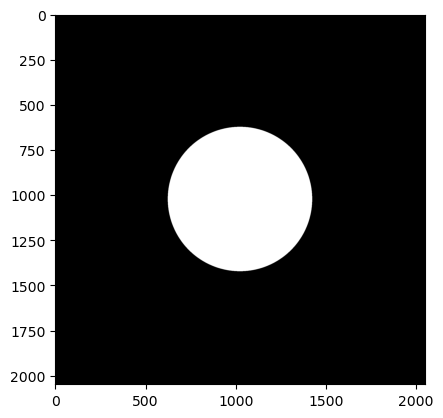

In [6]:
theta = 5 / 180 * math.pi
zo = 1.7
xo, yo = -math.tan(theta) * zo, 0
# E0 = get_parallel_wave((0, 0), np.stack((xx, yy), axis=0), zo)
E1 = pupil * get_parallel_wave((xo, yo), np.stack((xx, yy), axis=0), zo)
# E0 = get_exact_spherical_wave_np((0, 0), np.stack((xx, yy), axis=0), zo) #* get_lens_phase_shift(25e-3, np.stack((xx, yy), axis=0))
# E1 = pupil * get_exact_spherical_wave_np((xo, yo), np.stack((xx, yy), axis=0), zo) #* get_lens_phase_shift(25e-3, np.stack((xx, yy), axis=0))
plt.imshow(np.abs(E1), cmap='gray')
xs, ys = math.tan(theta) * z, 0

max freq: 366.92, interval: 0.36, length: (2048, 2048)


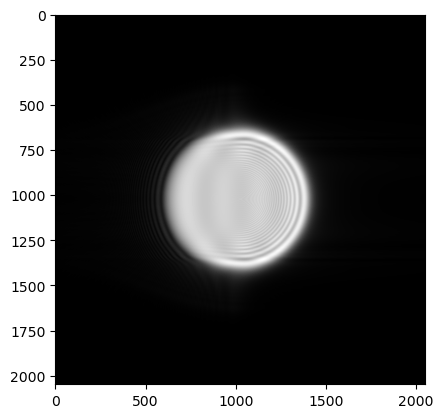

In [7]:
# from shift_BEASM_cpu import BEASM2d
# prop = BEASM2d(z, x, y, lam, 'cpu')
# U = prop(E1)
# plt.imshow(abs(U), cmap='gray')

from shift_BEASM_cpu import shift_BEASM2d
prop = shift_BEASM2d(xs, ys, z, x, y, lam)
U = prop(E1)
# U = U[..., N//2-r:N//2+r, N//2-r:N//2+r]
plt.imshow(np.abs(U), cmap='gray')

In [ ]:
from svASM import AngularSpectrumMethodMM
device =  'cuda:3' # 'cpu' #
prop = AngularSpectrumMethodMM((xo, yo, zo), z, x, y, x, y, lam, device, (xs, ys))
U = prop(E1)
plt.imshow(abs(U.cpu())[0], cmap='gray')

## analytical integral 

In [ ]:
j = 0
fun = lambda xn : 1/2/np.pi * z/np.sqrt((X[j]-xn)**2+z**2) * (1./np.sqrt((X[j]-xn)**2+z**2)-1j*k) * np.exp(1j*k*np.sqrt((X[j]-xn)**2+z**2)) / np.sqrt((X[j]-xn)**2+z**2)
fun(0)

In [ ]:
def complex_int(function, a, b):
    func_real = lambda x: function(x).real
    func_imag = lambda x: function(x).imag
    result_real = integrate.quad(func_real, -(r-1) * pitch, r * pitch)[0]
    result_imag = integrate.quad(func_imag, -(r-1) * pitch, r * pitch)[0]
    return result_real + 1j * result_imag

In [ ]:
X = np.linspace(-l/4, l/4 - pitch, N//2, dtype=np.double)
uu = []
for j in range(N//2):
      fun = lambda xn : 1/2/np.pi * z/np.sqrt((X[j]-xn)**2+z**2) * (1./np.sqrt((X[j]-xn)**2+z**2)-1j*k) * np.exp(1j*k*np.sqrt((X[j]-xn)**2+z**2)) / np.sqrt((X[j]-xn)**2+z**2)
      uu.append(complex_int(fun, -(r-1) * pitch, r * pitch))

uu = np.array(uu)
uu = uu / max(abs(uu))
phase_rsi = np.angle(uu)
amplitude_rsi = np.abs(uu)
plt.plot(X, amplitude_rsi)

## Impulse Response

In [ ]:
R = np.sqrt(x**2 + z**2)
kernel = 1 / 2 / np.pi * z / R * (1 / R - 1j * k) * np.exp(1j * k * R) / R
t_FT = fft.fftshift(fft.fft(fft.fftshift(c)))
kernel_FT = fft.fftshift(fft.fft(fft.fftshift(kernel)))
t_1 = fft.ifftshift(fft.ifft(fft.ifftshift(kernel_FT * t_FT)))
t_1  = t_1 / max(abs(t_1))
t_1 = t_1[N//2 - N//4 + 1 : N//2 + N//4 + 1]
plt.plot(x[N//2 - N//4 + 1 : N//2 + N//4 + 1], abs(t_1))

## BLASM

In [ ]:
fc = N * pitch / lam / z / 2  # f_limit
H = np.exp(1j * k * z * np.sqrt(1 - (s * lam)**2))
H[abs(s) > fc] = 0
t_FT = fft.fftshift(fft.fft(fft.fftshift(c)))
t_2 = fft.ifftshift(fft.ifft(fft.ifftshift(H * t_FT)))
t_2  = t_2 / max(abs(t_2))
t_2 = t_2[N//2 - N//4 + 1 : N//2 + N//4]
phase_asm_li = np.angle(t_2)
amplitude_asm_li = np.abs(t_2)
plt.plot(x[N//2 - N//4 + 1 : N//2 + N//4 + 1], amplitude_asm_li)

## BEASM

In [ ]:
# number of source points
n = 1024
r = n // 4
pad = 2
N = n * pad

pitch = 1e-6
z = 3  #
l = N * pitch

lam = 500e-6
k = 2 * np.pi / lam

# number of target points
M = N

# the source points
x = np.linspace(-l / 2, l / 2, N)
# y = np.linspace(-l / 2, l / 2, N)
# xx, yy = np.meshgrid(x, y)

# the target points
s = np.linspace(-1 / 2 / pitch, 1 / 2 / pitch - 1 / l, M)
# t = np.linspace(-1 / 2 / pitch, 1 / 2 / pitch - 1 / l, M)
# ss, tt = np.meshgrid(s, t)

In [ ]:
iflag = -1
eps = 1e-12
K = N / 2 / np.max(np.abs(s))
fcn = 1 / 2 * np.sqrt(N / lam / z)  # f_extend
ss = fcn / np.max(np.abs(s))
zc = N * pitch**2 / lam
if z < zc:
    fxn = s
else:
    fxn = s * (ss - 0.0)
H = np.exp(1j * k * (z * np.sqrt(1 - (fxn * lam)**2)))

c = pupil[N//2, :] + 1j * 0
t_asmNUFT = finufft.nufft1d3(x / np.max(np.abs(x)) * np.pi, c, fxn * K, isign=iflag, eps=eps)
t_3 = finufft.nufft1d3(x / (np.max(np.abs(x))) * np.pi, H * t_asmNUFT, fxn * K, isign=-iflag, eps=eps)

t_3 = t_3 / np.max(np.abs(t_3))
t_3 = t_3[N//2 - N//4 + 1 : N // 2 + N // 4 + 1]
phase_asm_ex = np.angle(t_3)
amplitude_asm_ex = np.abs(t_3)
plt.plot(x[N//2 - N//4 + 1 : N // 2 + N // 4 + 1], amplitude_asm_ex)

## BEASM 2D

In [ ]:
x_ = xx.flatten()
y_ = yy.flatten()
s_ = ss.flatten()
t_ = tt.flatten()

iflag = -1
eps = 1e-12
K1 = N / 2 / np.max(np.abs(s_))
K2 = N / 2 / np.max(np.abs(t_))
fcn = 1 / 2 * np.sqrt(N / lam / z)  # f_extend
ss_ = fcn / np.max(np.abs(s_))
tt_ = fcn / np.max(np.abs(t_))
zc = N * pitch**2 / lam
if z < zc:
    fxn = s_
    fyn = t_
else:
    fxn = s_ * (ss_ - 0.0)
    fyn = t_ * (tt_ - 0.0)
H = np.exp(1j * k * (z * np.sqrt(1 - (fxn * lam)**2 - (fyn * lam)**2)))

t_asmNUFT = finufft.nufft2d3(x_ / np.max(np.abs(x_)) * np.pi, y_ / np.max(np.abs(y_)) * np.pi, E0.flatten(), fxn * K1, fyn * K2, isign=iflag, eps=eps)
t_3 = finufft.nufft2d3(x_ / (np.max(np.abs(x_))) * np.pi, y_ / np.max(np.abs(y_)) * np.pi, H * t_asmNUFT, fxn * K1, fyn * K2, isign=-iflag, eps=eps).reshape(N, N)

t_3 = t_3 / np.max(np.abs(t_3))
# t_3 = t_3[N//2 - N//4 + 1 : N // 2 + N // 4 + 1]
# phase_asm_ex = np.angle(t_3)
amplitude_asm_ex = np.abs(t_3)
plt.imshow(amplitude_asm_ex)